# 🐫 **CAMEL Agent to MCP Server Conversion via .to_mcp() for FAISS RAG**


<div class="align-center">
  <a href="https://www.camel-ai.org/"><img src="https://i.postimg.cc/KzQ5rfBC/button.png"width="150"></a>
  <a href="https://discord.camel-ai.org"><img src="https://i.postimg.cc/L4wPdG9N/join-2.png"  width="150"></a></a>
  
⭐ <i>Star us on [*Github*](https://github.com/camel-ai/camel), join our [*Discord*](https://discord.camel-ai.org) or follow our [*X*](https://x.com/camelaiorg)
</div>

## Overview
This cookbook demonstrates how to convert a CAMEL RAG agent into an MCP server using the .to_mcp() method, allowing other MCP clients to use your agent as a tool.
## What You'll Learn
- How to create a self-contained RAG agent with embedded FAISS tools
- How to convert any CAMEL agent to an MCP server using `.to_mcp()`
- How to test the converted MCP server with a client


## 🎯 Key Concept: The .to_mcp() Method
The `.to_mcp()` method converts any CAMEL agent into an MCP server, making it available as a tool for other MCP clients.

```python
# Simple example from CAMEL documentation
from camel.agents import ChatAgent

agent = ChatAgent(model="gpt-4o-mini")
mcp_server = agent.to_mcp(name="demo", description="A demo agent")
mcp_server.run(transport="stdio")




# File 1: RAG Agent Configuration (faiss_rag_agent_config.py)

## Purpose: This file creates a self-contained RAG agent with embedded FAISS vector search tools.

## What it does:

Defines three core FAISS tools: create_faiss_index, query_faiss, and get_index_stats

- Implements simple text chunking and vector embeddings using numpy
- Creates a ChatAgent with Gemini model and embedded tools
- Provides a complete RAG system without external dependencies
- Self-contained: No external MCP server dependencies
- FAISS integration: Uses Facebook AI Similarity Search for vector operations
- Simple embeddings: Uses deterministic random embeddings for demonstration
- Tool composition: Wraps functions as FunctionTool objects for CAMEL


In [ ]:
import logging
import os
from camel.agents import ChatAgent
from camel.messages import BaseMessage
from camel.models import ModelFactory
from camel.types import ModelPlatformType, RoleType
from camel.toolkits import FunctionTool
import json
import numpy as np
import faiss

# Prevent logging since MCP needs to use stdout
root_logger = logging.getLogger()
root_logger.handlers = []
root_logger.addHandler(logging.NullHandler())

# Global variables for FAISS (now embedded in the agent)
dimension = 1536
index = faiss.IndexFlatL2(dimension)
documents_store = {}
document_id_counter = 0

def create_faiss_index_tool():
    """Create FAISS index tool as a regular function"""
    global document_id_counter, documents_store, index

    def create_faiss_index(documents: list, chunk_size: int = 1000) -> str:
        """Create a FAISS index from a list of document texts.

        Args:
            documents: List of document texts to index
            chunk_size: Size of text chunks for indexing (default: 1000)

        Returns:
            JSON string with status and results
        """
        global document_id_counter, documents_store, index

        try:
            # Reset the index
            index = faiss.IndexFlatL2(dimension)
            documents_store = {}
            document_id_counter = 0

            # Simple text chunking
            all_chunks = []
            for i, doc_text in enumerate(documents):
                words = doc_text.split()
                chunks = []

                for j in range(0, len(words), chunk_size//10):
                    chunk_words = words[j:j + chunk_size//10]
                    chunk_text = ' '.join(chunk_words)
                    if chunk_text.strip():
                        chunks.append(chunk_text)

                # Store document chunks
                for chunk in chunks:
                    documents_store[document_id_counter] = {
                        "text": chunk,
                        "metadata": {"source_id": i, "chunk_id": document_id_counter}
                    }
                    all_chunks.append(chunk)
                    document_id_counter += 1

            # Create simple embeddings
            if all_chunks:
                embeddings_list = []
                for chunk in all_chunks:
                    np.random.seed(hash(chunk) % (2**32))
                    embedding = np.random.normal(0, 1, dimension).astype(np.float32)
                    embeddings_list.append(embedding)

                # Add to FAISS index
                faiss_embeddings = np.array(embeddings_list, dtype=np.float32)
                index.add(faiss_embeddings)

                return json.dumps({
                    "status": "success",
                    "message": f"Indexed {document_id_counter} chunks from {len(documents)} documents",
                    "total_chunks": document_id_counter
                })
            else:
                return json.dumps({"error": "No text chunks were created"})

        except Exception as e:
            return json.dumps({"error": f"Error creating FAISS index: {str(e)}"})

    return FunctionTool(create_faiss_index)

def query_faiss_tool():
    """Create FAISS query tool as a regular function"""

    def query_faiss(query: str, top_k: int = 3) -> str:
        """Query the FAISS index with a natural language question.

        Args:
            query: The natural language query to search for
            top_k: Number of results to return (default: 3)

        Returns:
            JSON string with search results
        """
        global index, documents_store

        if index.ntotal == 0:
            return json.dumps({"error": "No documents have been indexed yet"})

        try:
            # Create query embedding
            np.random.seed(hash(query) % (2**32))
            query_embedding = np.random.normal(0, 1, dimension).astype(np.float32)
            query_embedding_np = np.array([query_embedding], dtype=np.float32)

            # Search the index
            distances, indices = index.search(query_embedding_np, min(top_k, index.ntotal))

            # Prepare results
            results = []
            for i, idx in enumerate(indices[0]):
                if idx != -1:
                    doc = documents_store[int(idx)]
                    results.append({
                        "text": doc["text"],
                        "metadata": doc["metadata"],
                        "score": float(1.0 / (1.0 + float(distances[0][i])))
                    })

            return json.dumps({"results": results})

        except Exception as e:
            return json.dumps({"error": f"Error querying FAISS index: {str(e)}"})

    return FunctionTool(query_faiss)

def get_index_stats_tool():
    """Create index stats tool as a regular function"""

    def get_index_stats() -> str:
        """Get statistics about the current FAISS index.

        Returns:
            JSON string with index statistics
        """
        global index, documents_store

        stats = {
            "total_chunks": index.ntotal,
            "dimension": index.d if index.ntotal > 0 else dimension,
            "stored_documents": len(documents_store)
        }

        return json.dumps(stats)

    return FunctionTool(get_index_stats)

def create_rag_agent():
    """Create a self-contained RAG agent with embedded FAISS tools (synchronous)"""

    # Create Gemini model
    model = ModelFactory.create(
        model_platform=ModelPlatformType.GEMINI,
        model_type="gemini-2.5-flash-preview-04-17",
        api_key=os.getenv("GOOGLE_API_KEY"),
        model_config_dict={
            "temperature": 0.2,
            # "max_output_tokens": 1024,
        }
    )

    # Create FAISS tools as regular functions (not MCP tools)
    tools = [
        create_faiss_index_tool(),
        query_faiss_tool(),
        get_index_stats_tool()
    ]

    # Define the RAG system message
    system_content = (
        "You are a helpful RAG assistant with embedded FAISS vector database capabilities. "
        "Your job is to help users find information by retrieving relevant content from documents. "
        "\nAvailable tools:\n"
        "1. create_faiss_index(documents, chunk_size) - Create a FAISS index from document texts\n"
        "2. query_faiss(query, top_k) - Search for information in the FAISS index\n"
        "3. get_index_stats() - Get statistics about the current index\n"
        "\nWorkflow:\n"
        "- First create an index with documents (if not already created)\n"
        "- Then query the index for relevant information\n"
        "- Use the retrieved content to answer user questions accurately\n"
        "- Always present retrieved information in a well-formatted way\n"
        "- If the index is empty or doesn't contain relevant information, be honest about it"
    )

    system_message = BaseMessage(
        role_name="RAG Assistant",
        role_type=RoleType.ASSISTANT,
        meta_dict={"task": "FAISS RAG Operations"},
        content=system_content
    )

    # Create the self-contained RAG agent
    rag_agent = ChatAgent(
        system_message=system_message,
        model=model,
        tools=tools
    )

    return rag_agent

# File 2: MCP Server Conversion (faiss_rag_agent_mcp_server.py)
## Purpose: This is the main file that demonstrates the agent-to-MCP conversion.

## What it does:
- Imports the RAG agent from the configuration file
- Uses the .to_mcp() method to convert the agent into an MCP server
- Runs the server with stdio transport for local communication

## Critical Points:
- Must be synchronous (no async/await) - let .to_mcp() handle event loops
- Requires GOOGLE_API_KEY environment variable


In [ ]:
import os
from faiss_rag_agent_config import create_rag_agent

def main():
    """Initialize and run the RAG agent as an MCP server"""

    # Ensure API key is set
    if not os.getenv("GOOGLE_API_KEY"):
        print("Error: GOOGLE_API_KEY environment variable not set")
        return

    # Create the self-contained RAG agent (synchronously)
    rag_agent = create_rag_agent()

    # Convert the agent to an MCP server using .to_mcp()
    mcp_server = rag_agent.to_mcp(
        name="RAG-Agent-MCP",
        description="A self-contained RAG assistant with FAISS vector search capabilities"
    )

    # Run the MCP server (synchronously, like in the reference)
    mcp_server.run(transport="stdio")

if __name__ == "__main__":
    main()

# File 3: Test Client (test_faiss_rag_mcp_client.py)
## Purpose: Tests the converted MCP server by connecting to it as a client.

## What it does:

- Creates an MCP configuration that points to your server script
- Connects to the MCP server using MCPToolkit
- Creates a client agent that can use the server's tools
- Provides an interactive interface to test RAG functionality



In [ ]:
import asyncio
import json
import os
import sys
from getpass import getpass
from pathlib import Path

from camel.agents import ChatAgent
from camel.logger import get_logger
from camel.messages import BaseMessage
from camel.models import ModelFactory
from camel.toolkits import MCPToolkit
from camel.types import ModelPlatformType, RoleType

logger = get_logger(__name__)

async def main():
    """Test the self-contained RAG MCP server"""

    # Configuration for connecting to our RAG MCP server
    rag_mcp_config = {
        "mcpServers": {
            "rag_agent_server": {
                "type": "script",
                "command": "python",
                "args": ["faiss_rag_agent_mcp_server.py"],
                "transport": "stdio",
                "env": {
                    "GOOGLE_API_KEY": os.getenv("GOOGLE_API_KEY") or getpass('Enter Gemini API key for server: ')
                }
            }
        }
    }

    # Write config file
    config_path = Path.cwd() / "rag_mcp_client_config.json"
    with open(config_path, 'w') as f:
        json.dump(rag_mcp_config, f, indent=2)

    # Get API key for client model
    gemini_api_key = getpass('Enter your Gemini API key for client: ')
    if not gemini_api_key:
        logger.error("API key is required to proceed.")
        return
    os.environ["GOOGLE_API_KEY"] = gemini_api_key

    # Connect to the RAG MCP server
    logger.info("Connecting to self-contained RAG MCP server...")
    mcp_toolkit = MCPToolkit(config_path=str(config_path))

    await mcp_toolkit.connect()
    tools = mcp_toolkit.get_tools()

    if not tools:
        logger.error("No tools found from the RAG MCP server")
        return

    logger.info(f"Found {len(tools)} tools from RAG MCP server")

    try:
        # Create a client model to interact with the RAG MCP server
        model = ModelFactory.create(
            model_platform=ModelPlatformType.GEMINI,
            model_type="gemini-2.5-flash-preview-04-17",
            api_key=gemini_api_key,
            model_config_dict={
                "temperature": 0.2,
                # "max_output_tokens": 1024,
            }
        )

        system_message = BaseMessage(
            role_name="RAG Client",
            role_type=RoleType.ASSISTANT,
            meta_dict={"task": "RAG MCP Client"},
            content="You are a client that uses a self-contained RAG MCP server for document search and retrieval tasks."
        )

        # Create client agent with RAG MCP tools
        client_agent = ChatAgent(
            system_message=system_message,
            model=model,
            tools=tools
        )
        client_agent.reset()

        print("\n=== Self-Contained RAG Agent as MCP Server Test ===\n")
        print("Testing CAMEL RAG agent (with embedded FAISS) exported as MCP server using .to_mcp()...")
        print("Type 'exit' to quit\n")

        # Test the RAG MCP server
        test_message = "Hello! Please create an index with documents about AI, machine learning, and FAISS, then search for information about vector databases."
        print(f"Test Query: {test_message}\n")

        response = await client_agent.astep(test_message)
        if response and response.msgs:
            print(f"RAG MCP Response: {response.msgs[0].content}\n")

        # Interactive loop
        while True:
            user_input = input("You: ")
            if user_input.lower() == 'exit':
                break

            response = await client_agent.astep(user_input)

            if response and response.msgs:
                agent_reply = response.msgs[0].content
                print(f"RAG MCP Agent: {agent_reply}\n")
            else:
                print("No response received.\n")

    except Exception as e:
        logger.error(f"An error occurred: {str(e)}")
        print(f"\nError: {str(e)}")
    finally:
        try:
            await mcp_toolkit.disconnect()
        except Exception as cleanup_error:
            logger.warning(f"Error during cleanup: {cleanup_error}")

if __name__ == "__main__":
    if sys.platform == "win32" and sys.version_info >= (3, 8):
        asyncio.set_event_loop_policy(asyncio.WindowsSelectorEventLoopPolicy())
    asyncio.run(main())

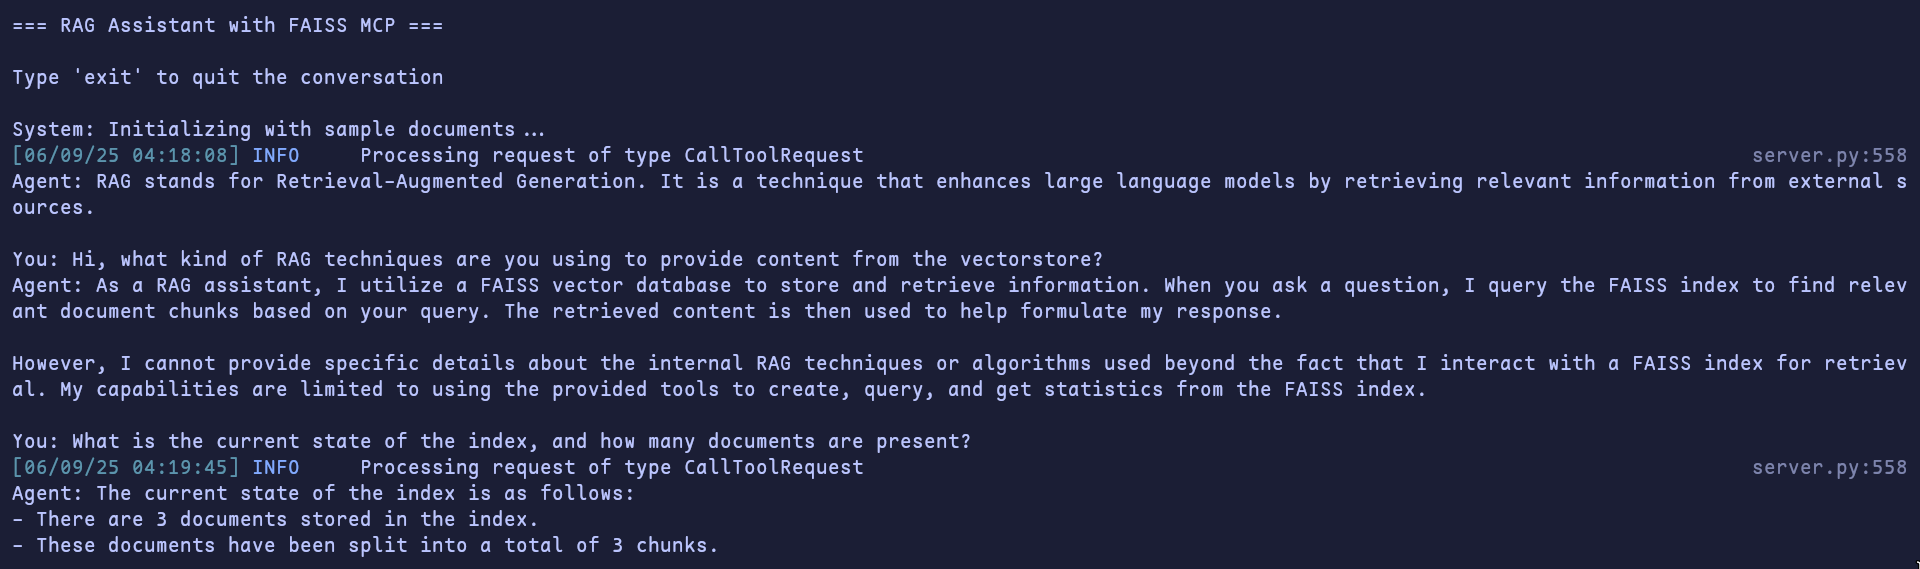

# Running the Example
## Step 1: Set Up Environment
```python
export GOOGLE_API_KEY="your-gemini-api-key-here"
```
## Step 2: Test the MCP Server (Optional)
This starts the server and waits for connections. If it runs without errors, the conversion worked!
```python
python faiss_rag_agent_mcp_server.py
```
## Step 3: Run the Client Test
```python
python test_faiss_rag_mcp_client.py
```


## Key Takeaways

### ✅ What We Accomplished

1. **Self-Contained Agent**: Created a RAG agent with embedded FAISS tools
2. **Agent → MCP Conversion**: Used `.to_mcp()` to convert the agent to an MCP server
3. **Cross-Client Compatibility**: The MCP server works with any MCP client
4. **Tool Composition**: Other agents can now use our RAG capabilities as tools


<div class="align-center">
  <a href="https://www.camel-ai.org/"><img src="https://i.postimg.cc/KzQ5rfBC/button.png"width="150"></a>
  <a href="https://discord.camel-ai.org"><img src="https://i.postimg.cc/L4wPdG9N/join-2.png"  width="150"></a></a>
  
⭐ <i>Star us on [*Github*](https://github.com/camel-ai/camel), join our [*Discord*](https://discord.camel-ai.org) or follow our [*X*](https://x.com/camelaiorg)
</div>